In [1]:
'''Implements a Y-Network using Functional API

~99.3% test accuracy
'''

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np

## see - from keras.layers.merge import concatenate
from keras.layers import Dense, Dropout, Input
from keras.layers import Conv2D, MaxPooling2D, Flatten
from keras.models import Model
from keras.layers.merge import concatenate
from keras.datasets import mnist
from keras.utils import to_categorical
from keras.utils import plot_model

Using TensorFlow backend.
/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
# load MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# from sparse label to categorical
num_labels = len(np.unique(y_train))
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# reshape and normalize input images
image_size = x_train.shape[1]
x_train = np.reshape(x_train,[-1, image_size, image_size, 1])
x_test = np.reshape(x_test,[-1, image_size, image_size, 1])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

In [3]:
# network parameters
input_shape = (image_size, image_size, 1)
batch_size = 32
kernel_size = 3
dropout = 0.4
n_filters = 32

# left branch of Y network
left_inputs = Input(shape=input_shape)
x = left_inputs
filters = n_filters
# 3 layers of Conv2D-Dropout-MaxPooling2D
# number of filters doubles after each layer (32-64-128)
for i in range(3):
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               padding='same',
               activation='relu')(x)
    x = Dropout(dropout)(x)
    x = MaxPooling2D()(x)
    filters *= 2          # double filters

# right branch of Y network
# 'dialation = 2 ' is applied
right_inputs = Input(shape=input_shape)
y = right_inputs
filters = n_filters
# 3 layers of Conv2D-Dropout-MaxPooling2D
# number of filters doubles after each layer (32-64-128)
for i in range(3):
    y = Conv2D(filters=filters,
               kernel_size=kernel_size,
               padding='same',
               activation='relu',
               dilation_rate=2)(y)
    y = Dropout(dropout)(y)
    y = MaxPooling2D()(y)
    filters *= 2

# merge left and right branches outputs
y = concatenate([x, y]) # y.shape = (None,3,3, 128 + 128)

# feature maps to vector in preparation to connecting to Dense layer
y = Flatten()(y)
y = Dropout(dropout)(y)
outputs = Dense(num_labels, activation='softmax')(y)

# build the model in functional API
model = Model([left_inputs, right_inputs], outputs)

# verify the model using graph
# plot_model(model, to_file='cnn-y-network.png', show_shapes=True)
# verify the model using layer text description
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 28, 28, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 28, 28, 32)   320         input_2[0][0]                    
__________________________________________________________________________________________________
dropout_1 

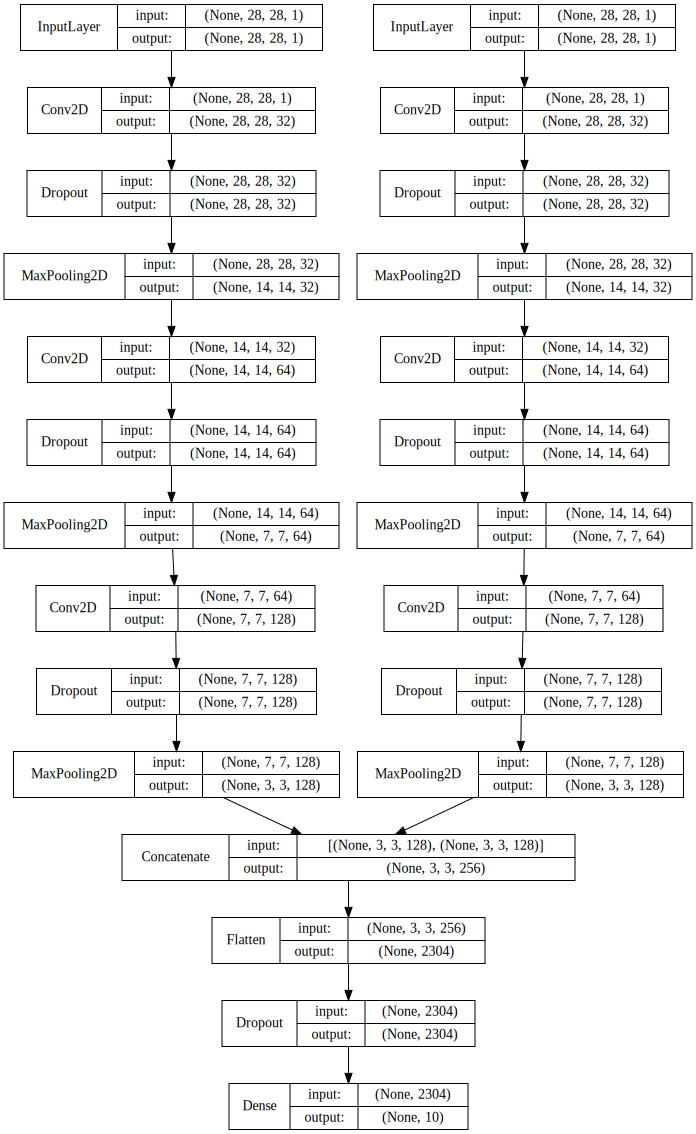

In [4]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

def plot_keras_model(model , show_shapes=True , show_layer_names=True):
    return SVG(model_to_dot(model , show_shapes=show_shapes , show_layer_names=show_layer_names).create(prog='dot',format='svg'))

plot_keras_model(model, show_shapes=True, show_layer_names=False)

In [5]:
# Save best checkpoint
import os
from keras.callbacks import ModelCheckpoint

# prepare model saving directory.
save_dir = os.path.join(os.getcwd(), 'saved_model')
# model_name = 'cnn-functional-2.1.1.{epoch:03d}.h5'
model_name = 'cnn-y-network-2.1.2-practice.h5'
if not os.path.isdir(save_dir):
        os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# save weights for future use (e.g. reload parameters w/o training)
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True)

callbacks = [checkpoint]

In [7]:
# classifier loss, Adam optimizer, classifier accuracy
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# train the model with input images and labels
model.fit([x_train, x_train],
          y_train, 
          validation_data=([x_test, x_test], y_test),
          epochs=5,
          batch_size=batch_size,
          callbacks=callbacks)

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 19s 322us/step - loss: 0.0560 - acc: 0.9826 - val_loss: 0.0803 - val_acc: 0.9907

Epoch 00001: val_loss improved from 0.12890 to 0.08027, saving model to /home/project/Advanced-Deep-Learning-With-Keras/chapter2-deep-networks/saved_model/cnn-y-network-2.1.2-practice.h5
Epoch 2/5
60000/60000 [==============================] - 20s 330us/step - loss: 0.0484 - acc: 0.9850 - val_loss: 0.0646 - val_acc: 0.9926

Epoch 00002: val_loss improved from 0.08027 to 0.06459, saving model to /home/project/Advanced-Deep-Learning-With-Keras/chapter2-deep-networks/saved_model/cnn-y-network-2.1.2-practice.h5
Epoch 3/5
60000/60000 [==============================] - 19s 319us/step - loss: 0.0441 - acc: 0.9861 - val_loss: 0.0466 - val_acc: 0.9926

Epoch 00003: val_loss improved from 0.06459 to 0.04656, saving model to /home/project/Advanced-Deep-Learning-With-Keras/chapter2-deep-networks/saved_model/cnn-

In [8]:
# model accuracy on test dataset
score = model.evaluate([x_test, x_test], y_test, batch_size=batch_size)
print("\nTest accuracy: %.1f%%" % (100.0 * score[1]))

10000/10000 [==============================] - 1s 103us/step

Test accuracy: 99.3%
